In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset

In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

# Import data

## Images

Get filenames

In [3]:
file_names = os.listdir('Data/images')
file_names[:5]

['models', 'Test_0.jpg', 'Test_1.jpg', 'Test_10.jpg', 'Test_100.jpg']

**Divide into Train and Test sets**

In [4]:
train_filenames = []
test_filenames = []
for file_name in file_names:
    if 'Train' in file_name:
        train_filenames.append(file_name)
    else: 
        test_filenames.append(file_name)
print(f'There are {len(train_filenames)} train images and {len(test_filenames)} test images')

There are 1821 train images and 1822 test images


See a sample

In [5]:
img = cv2.imread(f'Data/images/{train_filenames[0]}')
img.shape

(1365, 2048, 3)

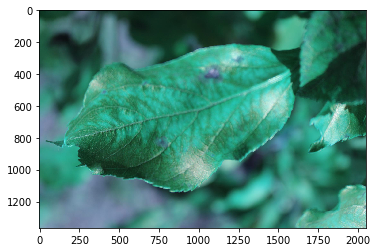

In [6]:
plt.imshow(img);

Load data into a numpy array with reduce image sizes

In [7]:
train_images = np.zeros((len(train_filenames), img.shape[0]//7,int((img.shape[0]//7)*1.5),3))
count = 0
for file in tqdm(train_filenames):
    image = cv2.imread(f'Data/images/{file}')
    small_img = cv2.resize(image, (int((img.shape[0]/7)*1.5), img.shape[0]//7), interpolation = cv2.INTER_CUBIC)
#     im_data = np.dot(small_img[...,:3], [0.2989, 0.5870, 0.1140])
#     im_data /= np.max(im_data)
    train_images[count,:,:,:] = small_img
    count += 1

In [8]:
# test_images = np.zeros((img.shape[0]//7,int((img.shape[0]/7)*1.5),(len(test_filenames))))
# count = 0
# for file in tqdm(test_filenames):
#     image = cv2.imread(f'Data/images/{file}')
#     small_img = cv2.resize(image, (int((img.shape[0]/7)*1.5), img.shape[0]//7), interpolation = cv2.INTER_CUBIC)
#     im_data = np.dot(small_img[...,:3], [0.2989, 0.5870, 0.1140])
#     im_data /= np.max(im_data)
#     test_images[:,:,count] = im_data
#     count += 1

See the new sample

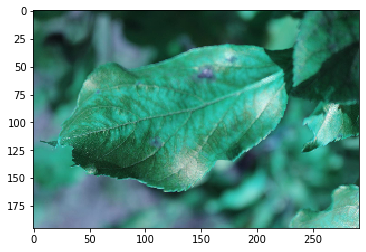

In [9]:
plt.imshow(np.array(train_images[0]).astype(np.int));

## Labels

In [10]:
train_labels = pd.read_csv('Data/train.csv')
test_labels = pd.read_csv('Data/test.csv')
train_labels.shape, test_labels.shape

((1821, 5), (1821, 1))

In [11]:
train_labels.head(2)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0


In [12]:
test_labels.head(2)

,image_id
0,Test_0
1,Test_1


The images have a different order than the labels

In [13]:
train_labels['idx'] = train_labels.image_id.apply(lambda x: train_filenames.index(x+'.jpg'))
train_labels.sort_values(by='idx', inplace=True)
# test_labels['idx'] = test_labels.image_id.apply(lambda x: test_filenames.index(x+'.jpg'))
# test_labels.sort_values(by='idx', inplace=True)
train_labels.head()

,image_id,healthy,multiple_diseases,rust,scab,idx
0,Train_0,0,0,0,1,0
1,Train_1,0,1,0,0,1
10,Train_10,0,0,1,0,2
100,Train_100,1,0,0,0,3
1000,Train_1000,0,0,1,0,4


In [14]:
label_list = ['healthy','multiple_diseases','rust','scab']

train_labels.loc[train_labels.healthy == 1, 'label'] = 'healthy'
train_labels.loc[train_labels.multiple_diseases == 1, 'label'] = 'multiple_diseases'
train_labels.loc[train_labels.rust == 1, 'label'] = 'rust'
train_labels.loc[train_labels.scab == 1, 'label'] = 'scab'

train_labels.loc[train_labels.healthy == 1, 'label_idx'] = label_list.index('healthy')
train_labels.loc[train_labels.multiple_diseases == 1, 'label_idx'] = label_list.index('multiple_diseases')
train_labels.loc[train_labels.rust == 1, 'label_idx'] = label_list.index('rust')
train_labels.loc[train_labels.scab == 1, 'label_idx'] = label_list.index('scab')
train_labels.head()

,image_id,healthy,multiple_diseases,rust,scab,idx,label,label_idx
0,Train_0,0,0,0,1,0,scab,3.0
1,Train_1,0,1,0,0,1,multiple_diseases,1.0
10,Train_10,0,0,1,0,2,rust,2.0
100,Train_100,1,0,0,0,3,healthy,0.0
1000,Train_1000,0,0,1,0,4,rust,2.0


# Train - Test sets split

In [128]:
X_train = train_images[:int(len(train_images)*0.8),:,:]
X_val = train_images[int(len(train_images)*0.8):,:,:]
X_train.shape, X_val.shape

((1456, 195, 292, 3), (365, 195, 292, 3))

In [129]:
y_train = np.array(train_labels[label_list].iloc[:int(train_images.shape[0]*0.8)].values.tolist())
y_val = np.array(train_labels[label_list].iloc[int(train_images.shape[0]*0.8):].values.tolist())
len(y_train), len(y_val)

(1456, 365)

# Modeling
**ResNet34 with Transfer Learning**

In [130]:
X_train, y_train, X_val, y_val = map(torch.tensor, (np.transpose(X_train, (0,3,1,2)), y_train, np.transpose(X_val, (0,3,1,2)), y_val))
X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([1456, 3, 195, 292]),
 torch.Size([1456, 4]),
 torch.Size([365, 3, 195, 292]),
 torch.Size([365, 4]))

In [131]:
image_datasets = dict()
image_datasets['train'] = TensorDataset(X_train, y_train)
image_datasets['val'] = TensorDataset(X_val, y_val)

In [195]:
dataloaders = dict()
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=8, num_workers=0)
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=8, num_workers=0)

In [196]:
# view data statistics by type
print('Number of training images: ', len(image_datasets['train']))
print('Number of test images: ', len(image_datasets['val']))

Number of training images:  1456
Number of test images:  365


In [197]:
# view tensor size 
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

print('Batch shape: ', images.size())

Batch shape:  torch.Size([8, 3, 195, 292])


## With transfer learning

In [212]:
# define pre-trained model
model = models.resnet34(pretrained=True)

# freeze parameters
for param in model.parameters():
    param.requires_grad = False
    
# print(model)    

In [213]:
# define new untrained network
classifier = nn.Sequential(nn.Linear(512, 256),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(256, 128),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(128, 64),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(64, 4),
                         nn.LogSoftmax(dim=1)
                        )
model.fc = classifier

In [214]:
# define hyperperameters
num_epochs = 6
learning_rate = 0.001

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [202]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [216]:
# train the model
model = model.cuda()

acc = []

for epoch in range(1, num_epochs+1):
    train_loss = []
    
    for batch_i, (data, target) in tqdm(enumerate(dataloaders['train']), total = len(dataloaders['train'])):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data.to(device=device, dtype=torch.float))
        loss = criterion(output, target.float())
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    
    scheduler.step()
    
    predicted = np.array([])
    validated = np.array([])

    model.eval()
    for (data, target) in tqdm(dataloaders['val']):
        data = data.cuda()
        output = model(data.to(device=device, dtype=torch.float))
        output = output.cpu().detach().numpy()
        for i, (e, n) in enumerate(list(zip(output, target))):
            predicted = np.append(predicted, np.argmax(e))
            validated = np.append(validated, np.argmax(n))

    acc.append(np.mean(predicted == validated))
    
    print(f'Epoch - {epoch} // Training Loss: {np.mean(train_loss):.4f} // Validation Accuracy: {np.mean(predicted == validated):.4f}')


Epoch - 1 // Training Loss: 0.5393 // Validation Accuracy: 0.3260



Epoch - 2 // Training Loss: 0.4668 // Validation Accuracy: 0.7562



Epoch - 3 // Training Loss: 0.3634 // Validation Accuracy: 0.7178



Epoch - 4 // Training Loss: 0.3229 // Validation Accuracy: 0.7753



Epoch - 5 // Training Loss: 0.3161 // Validation Accuracy: 0.7753



Epoch - 6 // Training Loss: 0.3131 // Validation Accuracy: 0.7781


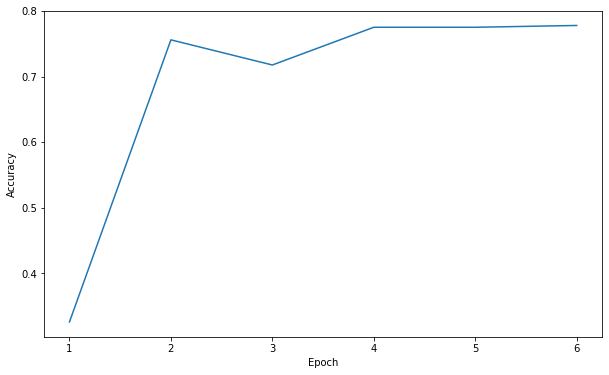

In [222]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(1,num_epochs+1), acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Without transfer learning

In [204]:
# define pre-trained model
model = models.resnet34(pretrained=False)

In [208]:
# define new untrained network
classifier = nn.Sequential(nn.Linear(512, 256),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(256, 128),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(128, 64),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(64, 4),
                         nn.LogSoftmax(dim=1)
                        )
model.fc = classifier

In [209]:
# define hyperperameters
num_epochs = 10
learning_rate = 0.001

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [210]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [211]:
# train the model
model = model.cuda()

acc = []

for epoch in range(1, num_epochs+1):
    train_loss = []
    
    for batch_i, (data, target) in tqdm(enumerate(dataloaders['train']), total = len(dataloaders['train'])):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data.to(device=device, dtype=torch.float))
        loss = criterion(output, target.float())
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    
    scheduler.step()
    
    predicted = np.array([])
    validated = np.array([])

    model.eval()
    for (data, target) in tqdm(dataloaders['val']):
        data = data.cuda()
        output = model(data.to(device=device, dtype=torch.float))
        output = output.cpu().detach().numpy()
        for i, (e, n) in enumerate(list(zip(output, target))):
            predicted = np.append(predicted, np.argmax(e))
            validated = np.append(validated, np.argmax(n))

    acc.append(np.mean(predicted == validated))
    
    print(f'Epoch - {epoch} // Training Loss: {np.mean(train_loss):.4f} // Validation Accuracy: {np.mean(predicted == validated):.4f}')


Epoch - 1 // Training Loss: 0.5434 // Validation Accuracy: 0.3260



Epoch - 2 // Training Loss: 0.5270 // Validation Accuracy: 0.3260



Epoch - 3 // Training Loss: 0.5229 // Validation Accuracy: 0.3507



Epoch - 4 // Training Loss: 0.5197 // Validation Accuracy: 0.4082



Epoch - 5 // Training Loss: 0.5188 // Validation Accuracy: 0.4192



Epoch - 6 // Training Loss: 0.5185 // Validation Accuracy: 0.4082



Epoch - 7 // Training Loss: 0.5181 // Validation Accuracy: 0.4219



Epoch - 8 // Training Loss: 0.5178 // Validation Accuracy: 0.4329



Epoch - 9 // Training Loss: 0.5177 // Validation Accuracy: 0.4274



Epoch - 10 // Training Loss: 0.5175 // Validation Accuracy: 0.4274


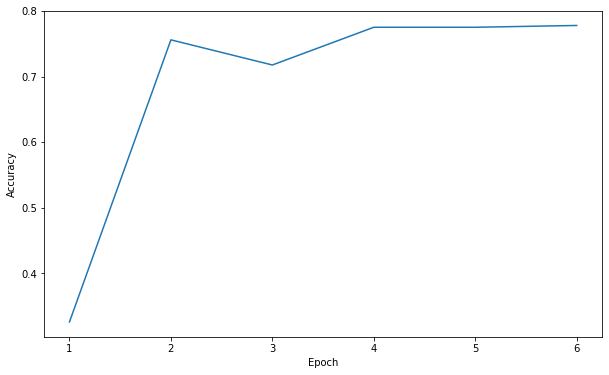

In [222]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(1,num_epochs+1), acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()